In [3]:
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
import itertools
%load_ext autoreload
%autoreload 2


# Dynamic Optimization Problem: Dentists

We start of by defining a set of parameters and then build our cost function that our agent is facing when deciding on going to the dentist or not. We plot our cost function. 
The basic idea is that it costs to go to the dentist every time you go, but if you postpone your check ups the total cost will increase.

In [25]:
par = SimpleNamespace()
par.x_t = 0 #x being the current level of usage of your teeth
par.FC = 10 #Fixed cost of going to the dentist
par.MC = 2 #Marginal cost of going to the dentist, depends on your usage of the teeth (when you last went)
par.beta = 0.6 #Discount factor
par.exponent = 2 #How bad your teeth decay if you don't see a dentist
par.gamma = 3
par.T = 3
par.boost = 10

In [5]:
def cost_dentist(par, d, x_t):
    if d == 0: 
        return  0 
    if d == 1: 
        return par.FC + par.MC*x_t #Person does not go to the dentist

In [6]:
def teeth_decay(par, d, x_t): #How your teeth are transitioning from one time period to the next
    if d == 0:
        x_1 = x_t**par.exponent + 3
    else:
        x_1 = max(x_t - par.boost, 0)
    return x_1

In [7]:
def disutil_ache(par, x_t): 
    if x_t < 2: 
        disutil = 3
    else: 
        disutil = np.sqrt(x_t) * par.gamma + x_t
    return disutil


In [8]:
def total_util(par, d, x_t):
    return -cost_dentist(par, d, x_t) - disutil_ache(par, x_t)

In [9]:
for i in range(0,10):
    print(disutil_ache(par, i))

3
3
6.242640687119286
8.196152422706632
10.0
11.70820393249937
13.348469228349533
14.937253933193773
16.48528137423857
18.0


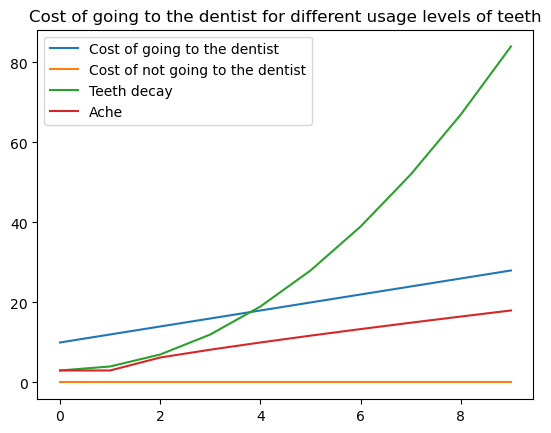

In [26]:
c_going = []
c_not_going = []
expo = []
logo = []
ache = []
decay = []
for i in range(0,10):
    c_going.append(cost_dentist(par,1, i))
    c_not_going.append(cost_dentist(par,0, i))
    decay.append(teeth_decay(par, 0, i))
    ache.append(disutil_ache(par, i))


plt.plot(c_going, label='Cost of going to the dentist')
plt.plot(c_not_going, label='Cost of not going to the dentist')
plt.plot(decay, label='Teeth decay')
plt.plot(ache, label='Ache')
plt.title('Cost of going to the dentist for different usage levels of teeth')
plt.legend()
plt.show()


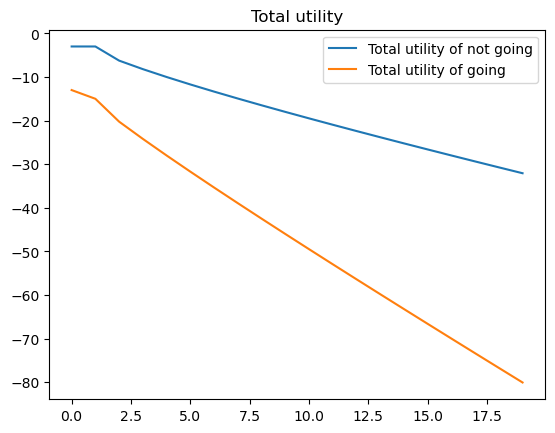

In [60]:
tot_util_go = []
tot_util_no = []

for i in range(0,20):
    tot_util_go.append(total_util(par, d = 1 , x_t= i))
    tot_util_no.append(total_util(par, d = 0 , x_t = i))


plt.plot(tot_util_no, label='Total utility of not going')
plt.plot(tot_util_go, label='Total utility of going')
plt.title('Total utility')
plt.legend()
plt.show()

In [59]:
#Say we start with some value and live for t time periods and you don't go to the dentist in the last time period.

#This is to get all possible combinations of decisions. Imagine every path of the decision tree
def n_combinations(t):
    digits = (0, 1)
    return list(itertools.product(digits, repeat=t-1))
x_start = 0
time = 13
possible_paths = n_combinations(time) #Create all decision combinations, excluding the last time period (d==0)
n_paths = len(possible_paths) #Game starts in t1 with a t0 value. 
x = np.zeros((n_paths, time)) #decay_path_matrix
x[:,0] = x_start #Change the first column, hence the starting value
a = np.zeros((n_paths, time)) #age path
v = np.zeros((n_paths,time+1))#value_matrix
d_index = np.zeros((n_paths)) #Initiate
decision_indexes = [] #Keeping track of indexes and storing values
for index, val in enumerate(possible_paths):
    #print('Decision path: ', index,val)
    for t, d in enumerate(val): 
        x_next = teeth_decay(par, d=d, x_t=x[index,t]) #You always start with zero
        x[index, (t+1)] = x_next
        v[index, (t+1)] = (par.beta**t)*total_util(par, d=d, x_t=x[index, t])
        #print('Dental usage in period', t, ' = ', x[index, t])
    v[index, -1] = (par.beta**(time+1))*total_util(par, d=0, x_t=x[index, -1])
    best_path = v.sum(axis=1).argmax() #The decision path maximizing total utility 
    best_decisions = possible_paths[best_path]
    
print(best_decisions,x[best_path])


/var/folders/yf/cbyzbr7d3hl8n98r3rphk8wh0000gn/T/ipykernel_13923/1663025369.py:3: RuntimeWarning: overflow encountered in double_scalars
  x_1 = x_t**par.exponent + 3


(0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0) [ 0.  3.  0.  3.  0.  3.  0.  3.  0.  3.  0.  3. 12.]


### Possible extensions: 

° Income and savings 

° Life style choices (healthy or unhealthy) with different impacts on x.

° Varying MC and FC

° Age impacting decay of teeth. Say after 50 years, consequences of not going (increase in x if d=0) goes up. Or marginal cost could double.

° Implementing a subsidy of one dollar. Does it make more sense to subsidize the marginal or the fixed cost. 

In [13]:
import numpy as np
from types import SimpleNamespace

# Define problem parameters
par = SimpleNamespace()
par.x_t = 0  # x being the current level of usage of your teeth
par.FC = 1  # Fixed cost of going to the dentist
par.MC = 2  # Marginal cost of going to the dentist, depends on your usage of the teeth (when you last went)
par.beta = 0.99  # Discount factor
par.exponent = 1.2  # How bad your teeth decay if you don't see a dentist
par.T = 5  # Time horizon
par.x_max = 10  # Maximum teeth quality level
par.gamma = 0.1
par.boost = 4



# Initialize value function
V = np.zeros((par.x_max+1,par.T))

# Iterate over time periods
for t in range(par.T-1, -1, -1):
    # Iterate over teeth quality levels
    for x in range(par.x_max+1):
        # Initialize variables
        min_cost = np.inf
        best_d = None

        if t == par.T: 
            total_cost = disutil_ache(par, x) ##Don't go to the dentist in the last time period, but endure pain
            best_d = 0
        
        else: 
            # Iterate over possible decisions
            for d in [0, 1]:
                # Calculate cost of current decision
                cost = cost_dentist(par, d, x)
                decay = teeth_decay(par, d, x)
                ache = disutil_ache(par, x)
                future_cost = par.beta*V[x,t-1]
                total_cost = cost + future_cost + ache
                
            # Update minimum cost and best decision
            if total_cost < min_cost:
                min_cost = total_cost
                best_d = d
            
        # Update value function
        V[x,t] = min_cost
        
        # Save best decision
        if best_d == 0:
            decision = 'Do not go to the dentist'
        else:
            decision = 'Go to the dentist'
        
        # Print results
        print(f"Time period: {t}, Teeth quality level: {x}, Best decision: {decision}, Expected cost: {min_cost}")


Time period: 4, Teeth quality level: 0, Best decision: Go to the dentist, Expected cost: 4.0
Time period: 4, Teeth quality level: 1, Best decision: Go to the dentist, Expected cost: 6.0
Time period: 4, Teeth quality level: 2, Best decision: Go to the dentist, Expected cost: 7.141421356237309
Time period: 4, Teeth quality level: 3, Best decision: Go to the dentist, Expected cost: 10.173205080756887
Time period: 4, Teeth quality level: 4, Best decision: Go to the dentist, Expected cost: 13.2
Time period: 4, Teeth quality level: 5, Best decision: Go to the dentist, Expected cost: 16.22360679774998
Time period: 4, Teeth quality level: 6, Best decision: Go to the dentist, Expected cost: 19.244948974278316
Time period: 4, Teeth quality level: 7, Best decision: Go to the dentist, Expected cost: 22.264575131106458
Time period: 4, Teeth quality level: 8, Best decision: Go to the dentist, Expected cost: 25.28284271247462
Time period: 4, Teeth quality level: 9, Best decision: Go to the dentist, E